# Redukce dimenzionality a Binární klasifikace

Importujeme potřebné balíčky a knihovny.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.decomposition import PCA
from sklearn.manifold import LocallyLinearEmbedding
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    classification_report,
)
import time

random_seed = 42

## Dataset

Načteme trénovací dataset a prohlédneme prvních 5 řádků. Na každém řádku jsou všechny pixely daného gray-scale obrázku, jejich hodnoty určují světlost pixelu. První sloupec _label_ potom reprezentuje typ oblečení, které obrázek představuje.


In [3]:
df = pd.read_csv("train.csv")
df.head()

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,1,0,0,1,0,...,0,0,0,0,95,132,90,0,0,0
2,1,0,0,0,0,0,0,3,0,23,...,94,68,44,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,1,0,...,57,0,0,0,26,71,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,2,0,6,156,149,78,0,0,0,0


Dataset obsahuje 784 sloupců s pixely a jeden sloupec _label_. Všchny sloupce jsou číselné.


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Columns: 785 entries, label to pixel784
dtypes: int64(785)
memory usage: 9.0 MB


Dataset neobsahuje žádné chybějící hodnoty. Hodnoty pixelů jsou v rozsahu 0 až 255. Hodnoty _label_ jsou pouze 0 nebo 1, jejich výskyt je v datasetu vyvážený (49,4% a 50,6%).


In [5]:
print(f"Chybějící hodnoty v trénovacích datech: {df.isnull().sum().sum()}")
df.describe()

Chybějící hodnoty v trénovacích datech: 0


,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
count,1500.000000,1500.0,1500.0,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,...,1500.000000,1500.000000,1500.0000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000,1500.000000
mean,0.494000,0.0,0.0,0.003333,0.014667,0.094000,0.172000,0.696667,1.560667,3.672000,...,45.751333,26.884000,12.8060,24.222667,36.824000,27.227333,10.798000,1.529333,0.129333,0.012667
std,0.500131,0.0,0.0,0.085599,0.196156,1.645692,1.935522,7.234884,12.065794,17.912854,...,60.907953,48.747801,32.4854,51.600777,65.053729,54.335598,31.792269,12.227598,3.098872,0.369591
min,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,4.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,86.000000,36.000000,1.0000,7.000000,55.500000,18.250000,0.000000,0.000000,0.000000,0.000000
max,1.000000,0.0,0.0,3.000000,5.000000,53.000000,52.000000,136.000000,216.000000,183.000000,...,240.000000,227.000000,231.0000,255.000000,249.000000,251.000000,244.000000,171.000000,97.000000,13.000000


Sloupec _label_ představuje vysvětlovanou proměnnou.


In [6]:
y = df["label"]
X = df.drop(columns="label")

print("Dimensions X (features):", X.shape)
print("Dimensions y (labels):", y.shape)

X_train, X_val, y_train, y_val = train_test_split(
    X, y, train_size=0.6, random_state=random_seed
)
X_val, X_test, y_val, y_test = train_test_split(
    X_val, y_val, train_size=0.5, random_state=random_seed
)

print("\nDimensions X_train (features):", X_train.shape)
print("Dimensions y_train (labels):", y_train.shape)

print("\nDimensions X_val (features):", X_val.shape)
print("Dimensions y_val (labels):", y_val.shape)

print("\nDimensions X_test (features):", X_test.shape)
print("Dimensions y_test (labels):", y_test.shape)

Dimensions X (features): (1500, 784)
Dimensions y (labels): (1500,)

Dimensions X_train (features): (900, 784)
Dimensions y_train (labels): (900,)

Dimensions X_val (features): (300, 784)
Dimensions y_val (labels): (300,)

Dimensions X_test (features): (300, 784)
Dimensions y_test (labels): (300,)


## Vizualizace datasetu

Zobrazíme obrázky, které reprezentují první 4 řádky trénovacího datasetu. Hodnota label **0** pravděpodobně reprezentuje šaty. Hodnota label **2** by reprezentovala nějaký svrchní díl oblečení (tričko/mikina).


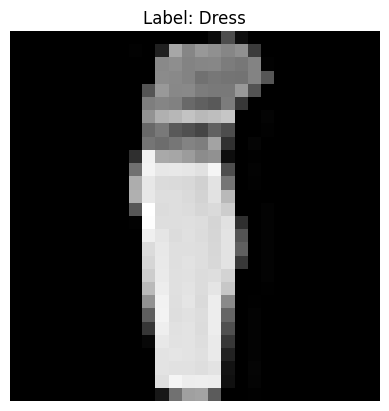

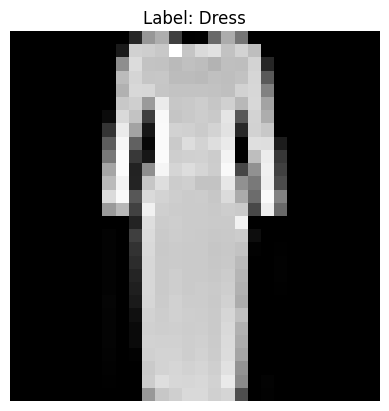

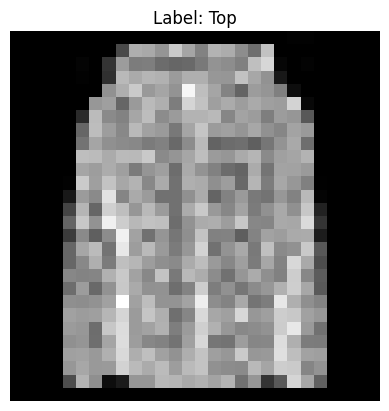

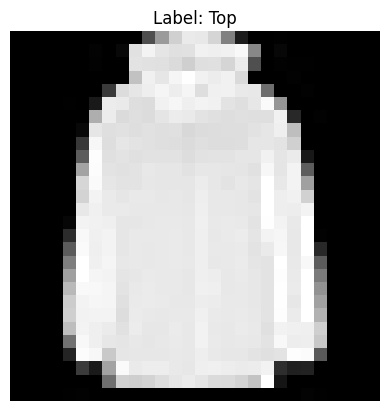

In [7]:
label_names = {0: "Top", 1: "Dress"}


def display_image(X: pd.DataFrame, y: pd.Series, index: int):
    """Displays a row as an image."""

    if isinstance(X, pd.DataFrame):
        image_vector = np.asarray(X.iloc[index])
    else:
        image_vector = np.asarray(X[index])

    image_2d = image_vector.reshape(28, 28)

    if isinstance(y, pd.Series):
        label = y.iloc[index]
    else:
        label = y[index]

    label_name = label_names[label]

    plt.imshow(image_2d, cmap="gray")
    plt.title(f"Label: {label_name}")
    plt.axis("off")
    plt.show()


display_image(X_train, y_train, 1)
display_image(X_train, y_train, 2)
display_image(X_train, y_train, 3)
display_image(X_train, y_train, 4)

Dále vizualizujeme obrázek tvořen minimem, průměrem, mediánem a maximem všech řádků. Z něj je zřejmé, že existuje vzor ve výskytu světlejších pixelů.


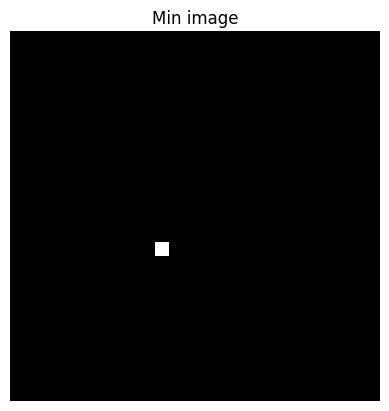

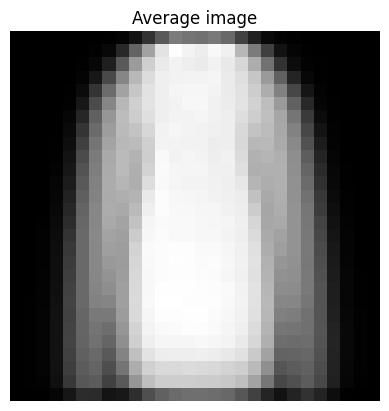

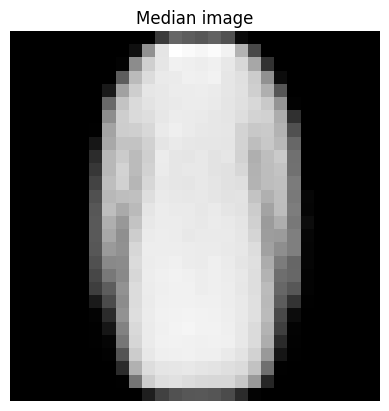

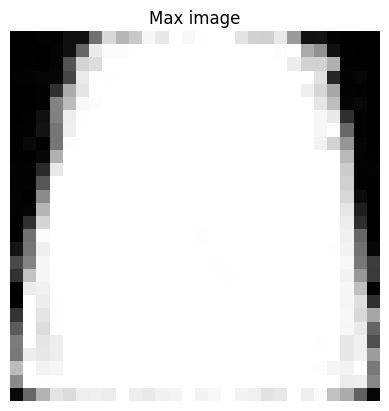

In [8]:
def display_average_image(X: pd.DataFrame):
    """Find average across all rows and display as an image."""

    image_vector = np.asarray(X)
    average_image = np.average(image_vector, axis=0)
    image_2d = average_image.reshape(28, 28)

    plt.imshow(image_2d, cmap="gray")
    plt.title(f"Average image")
    plt.axis("off")
    plt.show()


def display_min_image(X: pd.DataFrame):
    """Find min across all rows and display as an image."""

    image_vector = np.asarray(X)
    min_image = np.min(image_vector, axis=0)
    image_2d = min_image.reshape(28, 28)

    plt.imshow(image_2d, cmap="gray")
    plt.title(f"Min image")
    plt.axis("off")
    plt.show()


def display_max_image(X: pd.DataFrame):
    """Find max across all rows and display as an image."""

    image_vector = np.asarray(X)
    max_image = np.max(image_vector, axis=0)
    image_2d = max_image.reshape(28, 28)

    plt.imshow(image_2d, cmap="gray")
    plt.title(f"Max image")
    plt.axis("off")
    plt.show()


def display_median_image(X: pd.DataFrame):
    """Find median across all rows and display as an image."""

    image_vector = np.asarray(X)
    median_image = np.median(image_vector, axis=0)
    image_2d = median_image.reshape(28, 28)

    plt.imshow(image_2d, cmap="gray")
    plt.title(f"Median image")
    plt.axis("off")
    plt.show()


display_min_image(X_train)
display_average_image(X_train)
display_median_image(X_train)
display_max_image(X_train)

Nyní vizualizujeme distribuci typů oblečení na trénovacím datasetu. Dle očekávání je velmi vyvážený.


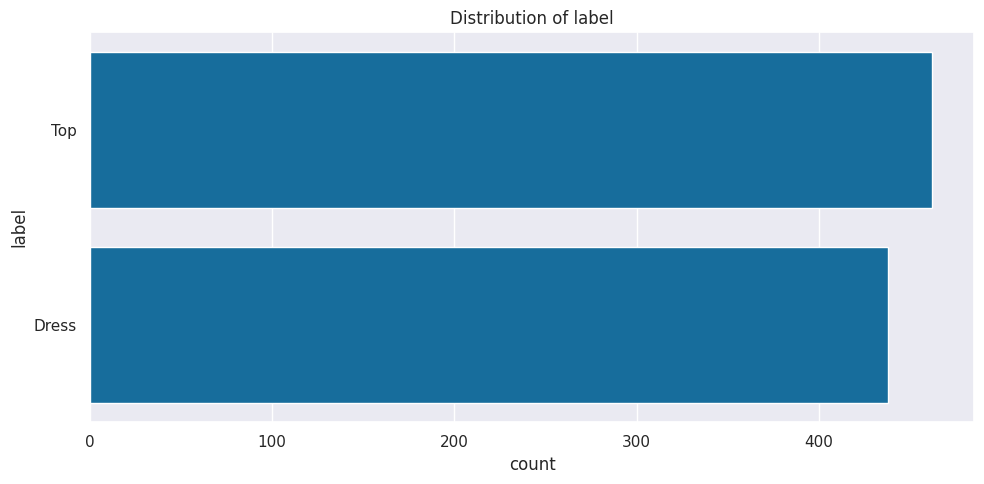

In [9]:
def plot_label_distribution(y: pd.Series):
    """Plots a graph of the label distribution."""

    plt.figure(figsize=(10, 5))
    sns.set_theme(palette="colorblind")
    sns.countplot(y=y, order=y.value_counts().index)
    plt.title("Distribution of label")
    plt.ylabel("label")
    plt.yticks(ticks=range(len(label_names)), labels=label_names.values())
    plt.tight_layout()
    plt.show()


plot_label_distribution(y_train)

Příprávíme si funkci pro ohodnocení natrénovaného modelu.


In [10]:
def evaluate_model(model_name, model, X, y, examples_count=4):
    """Evaluates a classification model based on common metrics."""

    print(f"Evaluating {model_name} model")

    # Time the prediction speed
    start_time = time.time()
    y_pred = model.predict(X)
    end_time = time.time()
    print(f" - Prediction time = {end_time - start_time:.2f} seconds")
    accuracy = accuracy_score(y, y_pred)
    print(f" - Accuracy = {accuracy * 100:0.2f}%")
    f1 = f1_score(y, y_pred)
    print(f" - F1 score = {f1 * 100:0.2f}%")

    print(f"\nClassification report")
    report = classification_report(y, y_pred, target_names=label_names.values())
    print(report)

    print(f"\nMissclassified images")

    misclassified_indices = np.where(y != y_pred)[0]

    if not misclassified_indices.size:
        print(" - No misclassifications found!")
    else:
        to_show_count = min(examples_count, len(misclassified_indices))
        indices_to_show = np.random.choice(
            misclassified_indices, size=to_show_count, replace=False
        )
        for index in indices_to_show:
            display_image(X, y, index)

    return accuracy

## Trénování


Ke škálování vyzkoušíme více metod. Přidáme i jednu vlastní a to jednoduché vydělení 255.


In [11]:
class DivideScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Fitting not needed

    def transform(self, X):
        return X / 255

In [12]:
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
divide_scaler = DivideScaler()

scaler_names = ["no-scaling", "standard-scaling", "min-max-scaling", "divide-scaling"]
scalers = ["passthrough", StandardScaler(), MinMaxScaler(), DivideScaler()]

Ke trénování použijeme **GridSearchCV** pro dobrou implementaci křížové validace a paralelnímu ladění.


In [13]:
def tune_hyperparameters(
    name: str,
    param_grid: dict | list[dict],
    pipeline: Pipeline,
    X: pd.DataFrame,
    y: pd.Series,
    verbose=0,
    random=False,
):

    if random:
        grid_search = RandomizedSearchCV(
            estimator=pipeline,
            param_distributions=param_grid,
            cv=5,
            n_jobs=-1,
            n_iter=200,
            verbose=verbose,
        )
    else:
        grid_search = GridSearchCV(
            estimator=pipeline,
            param_grid=param_grid,
            cv=5,
            n_jobs=-1,
            verbose=verbose,
        )

    grid_search.fit(X, y)

    print(
        f"Best score ({name}) = {grid_search.best_score_}, with hyperparameters:",
        grid_search.best_params_,
    )

    return grid_search.best_estimator_

### Škálování


Ke škálování vyzkoušíme více metod. Přidáme i jednu vlastní a to jednoduché vydělení 255.


In [14]:
class DivideScaler(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self  # Fitting not needed

    def transform(self, X):
        return X / 255


standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler()
divide_scaler = DivideScaler()

scaler_names = ["no-scaling", "standard-scaling", "min-max-scaling", "divide-scaling"]
scalers = ["passthrough", StandardScaler(), MinMaxScaler(), DivideScaler()]

V následující sekci otestujeme, zda škálování hraje významnou roli ve výkonu testovaných modelů.


In [15]:
def test_scalers(
    name: str,
    param_grid: dict | list[dict],
    pipeline: Pipeline,
    X: pd.DataFrame,
    y: pd.Series,
):
    for scaler_name, scaler in zip(scaler_names, scalers):
        if isinstance(param_grid, list):
            for dictionary in param_grid:
                dictionary["scaler"] = [scaler]
        else:
            param_grid["scaler"] = [scaler]

        tune_hyperparameters(f"{name}-{scaler_name}", param_grid, pipeline, X, y)

Pro model SVM jsou rozdíly v přesnosti zanedbatelné. Zdá se ale, že jádro **poly** těží ze standardizace a společně konkurují jádru **rbf**, které normálně vede.


In [16]:
pipeline_svm = Pipeline([("scaler", None), ("cls", SVC())])

test_grid_svm = {
    "scaler": None,
    "cls__kernel": ["linear", "rbf", "poly"],
    "cls__C": [0.1, 1, 10, 100],
}

test_scalers("SVM", test_grid_svm, pipeline_svm, X_train, y_train)

Best score (SVM-no-scaling) = 0.95, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'scaler': 'passthrough'}
Best score (SVM-standard-scaling) = 0.9522222222222222, with hyperparameters: {'cls__C': 10, 'cls__kernel': 'poly', 'scaler': StandardScaler()}
Best score (SVM-min-max-scaling) = 0.9488888888888889, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'scaler': MinMaxScaler()}
Best score (SVM-divide-scaling) = 0.95, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'scaler': DivideScaler()}


Pro model GNB byly rozdíly v přesnosti také zanedbatelné.


In [17]:
pipeline_gnb = Pipeline([("scaler", None), ("cls", GaussianNB())])
test_grid_gnb = {"cls__var_smoothing": np.logspace(-9, -2, num=8)}
test_scalers("Naive-Bayes", test_grid_gnb, pipeline_gnb, X_train, y_train)

Best score (Naive-Bayes-no-scaling) = 0.8855555555555557, with hyperparameters: {'cls__var_smoothing': np.float64(1e-05), 'scaler': 'passthrough'}
Best score (Naive-Bayes-standard-scaling) = 0.8811111111111112, with hyperparameters: {'cls__var_smoothing': np.float64(0.01), 'scaler': StandardScaler()}
Best score (Naive-Bayes-min-max-scaling) = 0.8844444444444445, with hyperparameters: {'cls__var_smoothing': np.float64(0.001), 'scaler': MinMaxScaler()}
Best score (Naive-Bayes-divide-scaling) = 0.8855555555555557, with hyperparameters: {'cls__var_smoothing': np.float64(1e-05), 'scaler': DivideScaler()}


I pro model LDA byly rozdíly zanedbatelné. Z testování ale vzešel solver **lsqr** jako lepší oproti solveru **svd**.


In [18]:
pipeline_lda = Pipeline([("scaler", None), ("cls", LinearDiscriminantAnalysis())])
test_grid_lda = [
    {
        "scaler": None,
        "cls__solver": ["svd"],
    },
    {
        "scaler": None,
        "cls__solver": ["lsqr"],
        "cls__shrinkage": [None, "auto", 0, 0.3, 0.4, 0.5, 1],
    },
]
lda = test_scalers("LDA", test_grid_lda, pipeline_lda, X_train, y_train)

Best score (LDA-no-scaling) = 0.9466666666666667, with hyperparameters: {'cls__shrinkage': 0.4, 'cls__solver': 'lsqr', 'scaler': 'passthrough'}
Best score (LDA-standard-scaling) = 0.9444444444444444, with hyperparameters: {'cls__shrinkage': 0.4, 'cls__solver': 'lsqr', 'scaler': StandardScaler()}
Best score (LDA-min-max-scaling) = 0.9466666666666667, with hyperparameters: {'cls__shrinkage': 0.4, 'cls__solver': 'lsqr', 'scaler': MinMaxScaler()}
Best score (LDA-divide-scaling) = 0.9466666666666667, with hyperparameters: {'cls__shrinkage': 0.4, 'cls__solver': 'lsqr', 'scaler': DivideScaler()}


Jelikož škálování **nehraje** významnou roli ve výkonu modelů, v zájmu interpretovatelnosti a jednoduchosti nepoužijeme škálování žádné. Zachováme tak přirozený charakter datasetu odpovídající reprezentaci gray-scale obrázku.


### Ladění hyperparametrů


In [19]:
param_grid_svm = [
    {
        "cls__kernel": ["linear"],
        "cls__C": [0.1, 1, 10],
    },
    {
        "cls__kernel": ["rbf"],
        "cls__C": [0.1, 1, 10, 100],
        "cls__gamma": [0.001, 0.01, 0.1, "scale", "auto"],
    },
    {
        "cls__kernel": ["poly"],
        "cls__C": [0.1, 1, 10],
        "cls__degree": [2, 3],
        "cls__gamma": ["scale", "auto", 0.1],
    },
]

pipeline_svm = Pipeline([("cls", SVC())])
svm = tune_hyperparameters("SVM", param_grid_svm, pipeline_svm, X_train, y_train)

Best score (SVM) = 0.95, with hyperparameters: {'cls__C': 1, 'cls__gamma': 'scale', 'cls__kernel': 'rbf'}


In [20]:
pipeline_nb = Pipeline([("cls", GaussianNB())])
param_grid_nb = {"cls__var_smoothing": np.logspace(-20, 0, num=50)}
nb = tune_hyperparameters("Naive-Bayes", param_grid_nb, pipeline_nb, X_train, y_train)

Best score (Naive-Bayes) = 0.8855555555555557, with hyperparameters: {'cls__var_smoothing': np.float64(1.2648552168552958e-05)}


In [21]:
pipeline_lda = Pipeline([("cls", LinearDiscriminantAnalysis())])
param_grid_lda = [
    {
        "cls__solver": ["svd"],
    },
    {
        "cls__solver": ["lsqr"],
        "cls__shrinkage": [None, "auto", 0, 0.3, 0.35, 0.4, 0.45, 0.5, 1],
    },
]
lda = tune_hyperparameters("LDA", param_grid_lda, pipeline_lda, X_train, y_train)

Best score (LDA) = 0.9466666666666667, with hyperparameters: {'cls__shrinkage': 0.4, 'cls__solver': 'lsqr'}


## Evaluace

SVM by si mohl dobře poradit s vysokou dimenzí obrázkových dat. Vhodné jádro dokáže pracovat se silnou prostorovou závislosti jednotlivých pixelů.


Evaluating Support vector machine model
 - Prediction time = 0.05 seconds
 - Accuracy = 92.67%
 - F1 score = 92.03%

Classification report
              precision    recall  f1-score   support

         Top       0.94      0.93      0.93       163
       Dress       0.91      0.93      0.92       137

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


Missclassified images


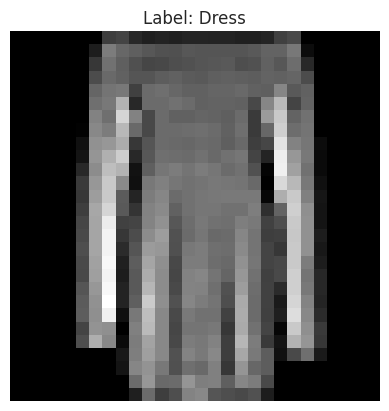

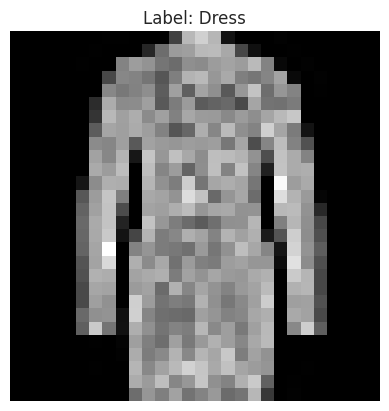

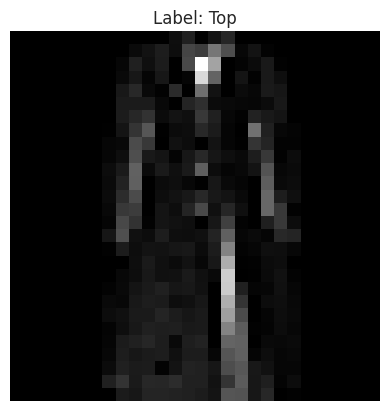

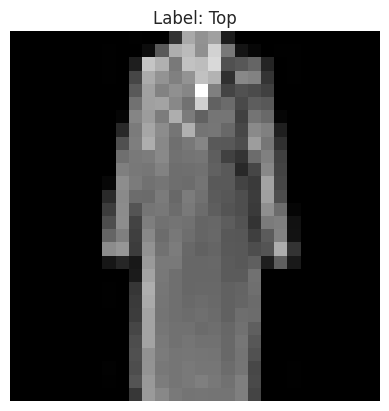

In [22]:
accuracy_svm = evaluate_model("Support vector machine", svm, X_val, y_val)

Model Naivního Bayese předpokládá nezávislost příznaků (pixelů) podmíněně na třídě. Tento předpoklad je u obrazových dat zásadně porušen. Model si pravděpodobně dobře poradí s pozadím obrázků, ale bude mít potíže zachytit prostorové závislosti důležité pro identifikaci tvaru.


Evaluating Gaussian Naive-Bayes model
 - Prediction time = 0.00 seconds
 - Accuracy = 85.67%
 - F1 score = 85.81%

Classification report
              precision    recall  f1-score   support

         Top       0.95      0.78      0.86       163
       Dress       0.78      0.95      0.86       137

    accuracy                           0.86       300
   macro avg       0.87      0.86      0.86       300
weighted avg       0.87      0.86      0.86       300


Missclassified images


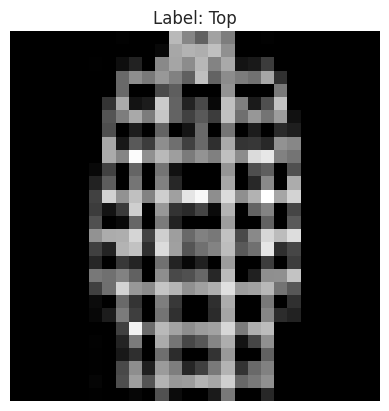

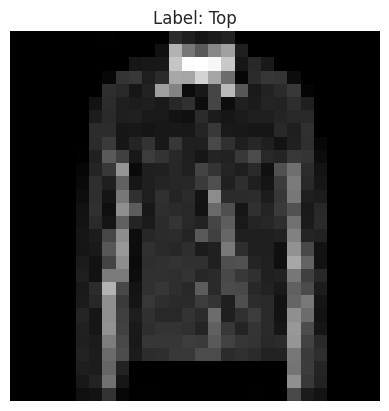

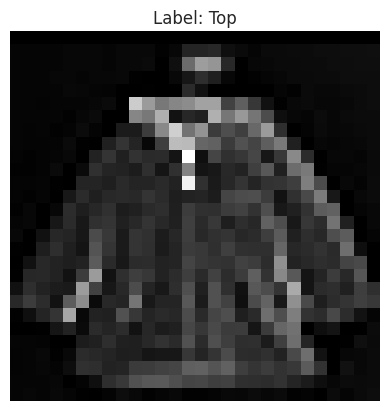

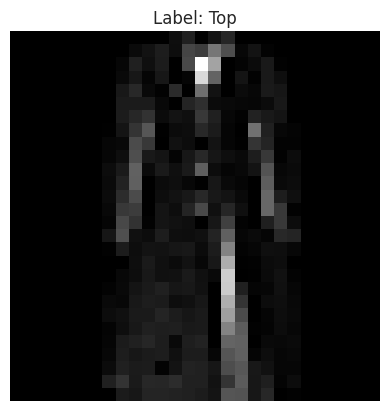

In [23]:
accuracy_gnb = evaluate_model("Gaussian Naive-Bayes", nb, X_val, y_val)

Lineární diskriminační analýza z principu svého chování obsahuje vestavěnou redukci dimenzionality, poradí si tedy s vysokou dimenzí vstupních dat. Předpoklad normality dat a stejné kovarianční matice pro všechny třídy je porušen, není to ale tak zásadní problém jako u GNB. Jsou-li třídy dobře lineárně separabilní, bude fungovat relativně dobře.


Evaluating Linear Discrimination Analysis model
 - Prediction time = 0.00 seconds
 - Accuracy = 91.00%
 - F1 score = 90.18%

Classification report
              precision    recall  f1-score   support

         Top       0.92      0.91      0.92       163
       Dress       0.90      0.91      0.90       137

    accuracy                           0.91       300
   macro avg       0.91      0.91      0.91       300
weighted avg       0.91      0.91      0.91       300


Missclassified images


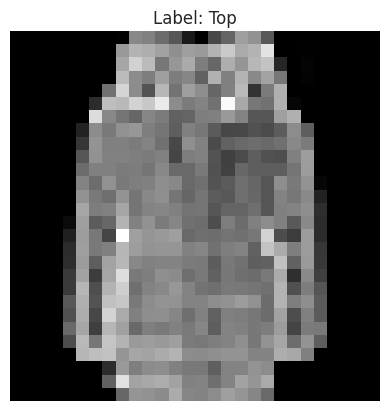

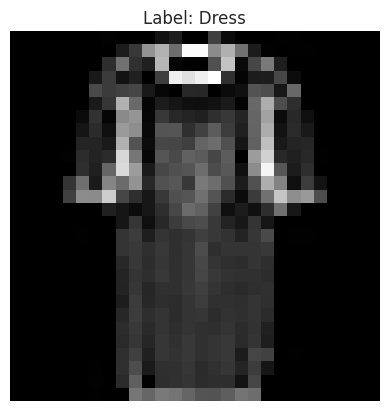

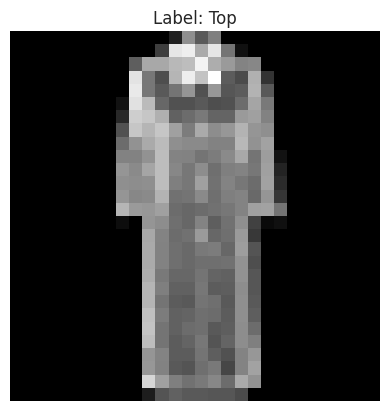

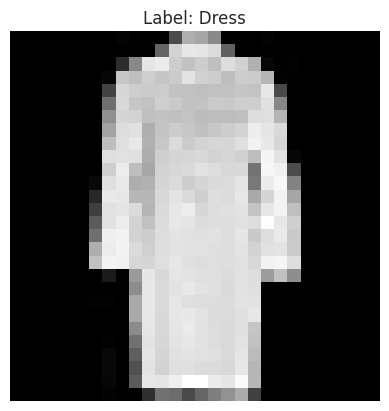

In [24]:
accuracy_lda = evaluate_model("Linear Discrimination Analysis", lda, X_val, y_val)

## Generování dat


### Gaussian Naive-Bayes

Naivní bayesovský klasifikátor pracuje s pravděpodobnostmi příznaků jako nezávislými. Pravděpodobně si tedy relativně dobře poradí s pozadím, bude ale mít velký problém vystihnout prostorové závislosti, které jsou pro obrázek typické.


In [45]:
def generate_samples_from_gnb(
    gnb_model: GaussianNB,
    samples_count: int,
    class_index: int | None = None,
):
    means = gnb_model.theta_
    variances = gnb_model.var_
    priors = gnb_model.class_prior_
    classes = gnb_model.classes_
    features_count = gnb_model.n_features_in_

    generated_X = np.zeros((samples_count, features_count))
    generated_y = np.zeros(samples_count)

    rng = np.random.default_rng()

    for i in range(samples_count):
        if class_index is None:
            class_index = rng.choice(len(classes), p=priors)
        class_means = means[class_index, :]
        class_variances = variances[class_index, :]
        class_stds = np.sqrt(class_variances)

        generated_X[i] = rng.normal(class_means, class_stds)
        generated_y[i] = classes[class_index]

    return generated_X, generated_y

Oba druhy oblečení jsou mimo hrubý tvar v podstatě nerozeznatelné. Tento přístup ke generování dat není ideální.


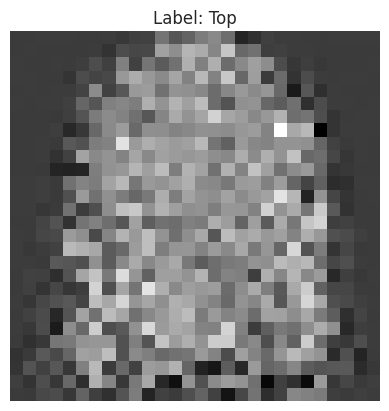

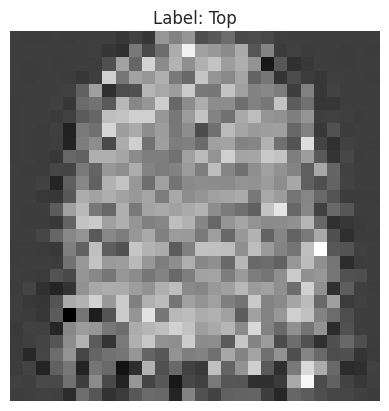

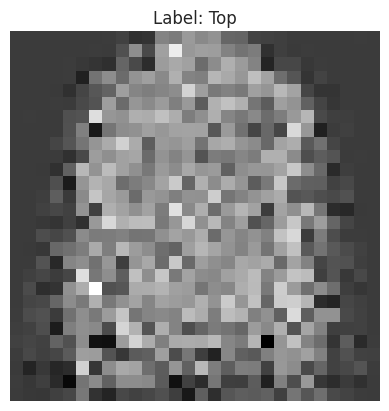

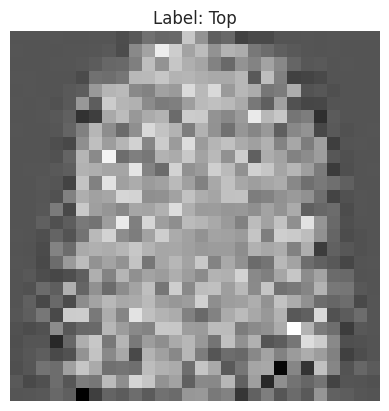

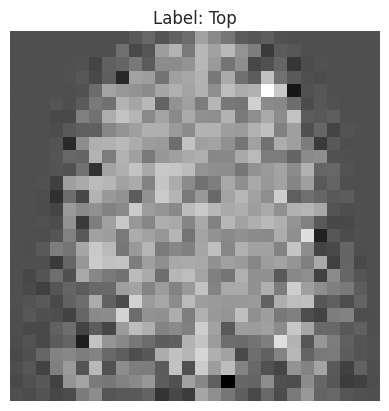

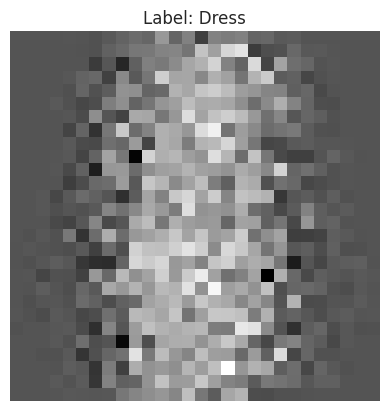

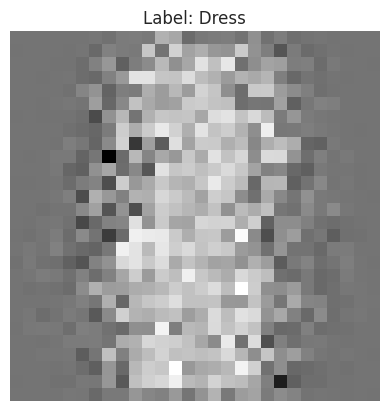

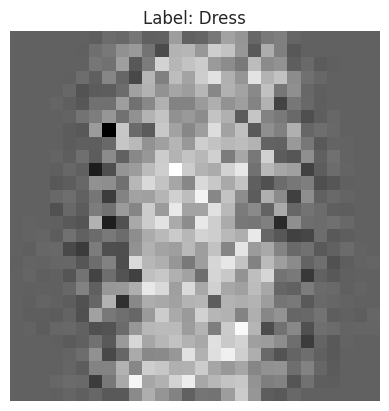

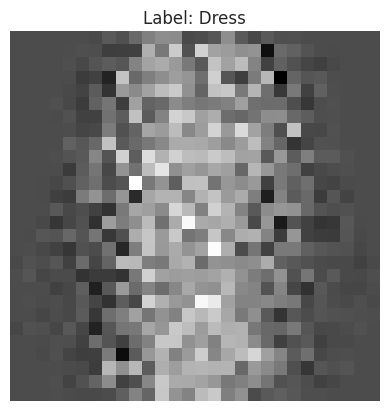

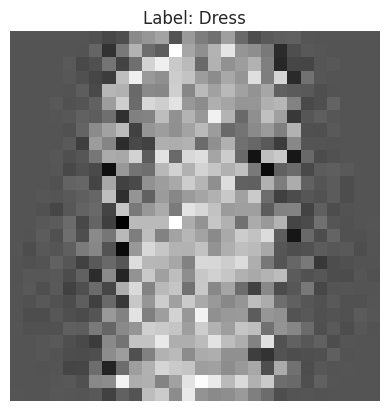

In [47]:
nb_model = nb["cls"]

top_X, top_y = generate_samples_from_gnb(nb_model, 5, 0)
dress_X, dress_y = generate_samples_from_gnb(nb_model, 5, 1)

for i in range(5):
    display_image(top_X, top_y, i)
for i in range(5):
    display_image(dress_X, dress_y, i)

### Lineární diskriminační analýza

Modelu lineární diskriminační analýzy by se mohlo povést lépe zachytit společné charakteristiky jednotlivých tříd oblečení. Možné komplikace mohou vzejít ze zpětné projekce z méně dimenzionálního prostoru.


In [43]:
def generate_samples_from_lda(
    lda_model: LinearDiscriminantAnalysis,
    samples_count: int,
    class_index: int | None = None,
):
    means = lda_model.means_
    covariance = lda_model.covariance_
    priors = lda_model.priors_
    classes = lda_model.classes_
    features_count = means.shape[1]

    generated_X = np.zeros((samples_count, features_count))
    generated_y = np.zeros(samples_count)

    rng = np.random.default_rng()

    for i in range(samples_count):
        if class_index is None:
            class_index = np.random.choice(len(classes), p=priors)
        generated_X[i] = rng.multivariate_normal(means[class_index], covariance)
        generated_y[i] = classes[class_index]

    return generated_X, generated_y

Obrázky obsahují rozeznatelné rysy odpovídající jejich třídám (délka rukávů, šířka a tvar oblečení). Tento způsob generace je tedy významně lepší. Obrázky jsou ale velmi zašuměné, pravděpodobně způsobené zmíněnou zpětnou projekcí.


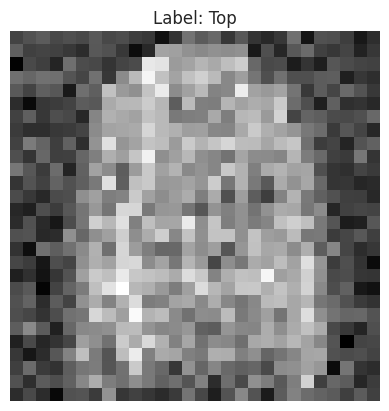

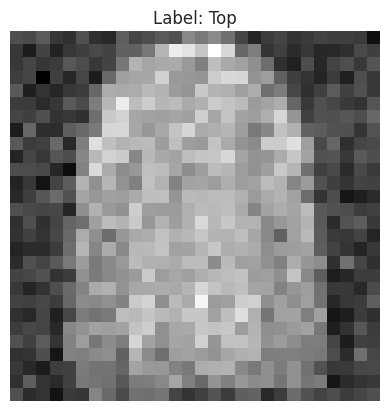

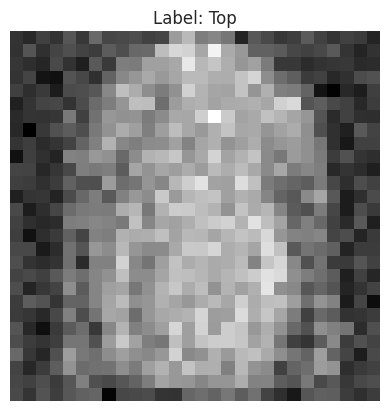

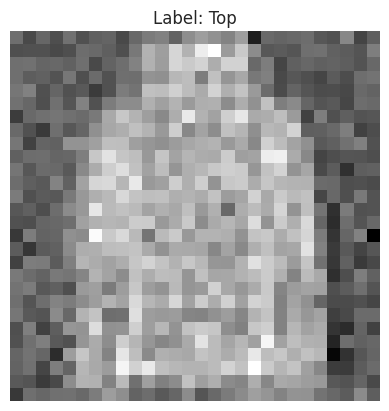

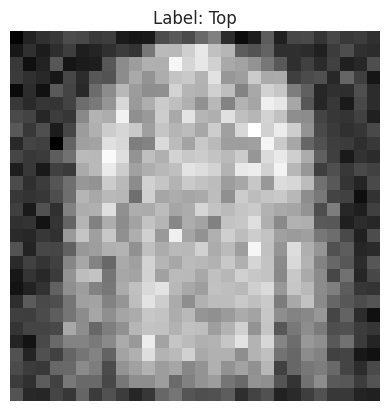

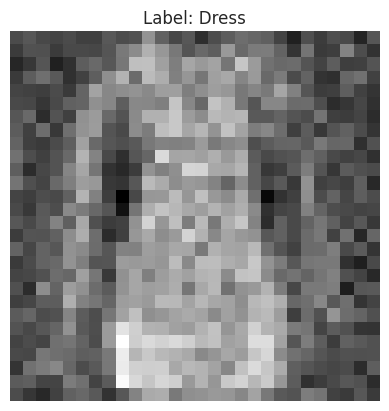

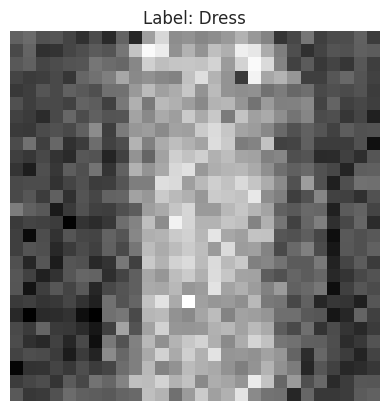

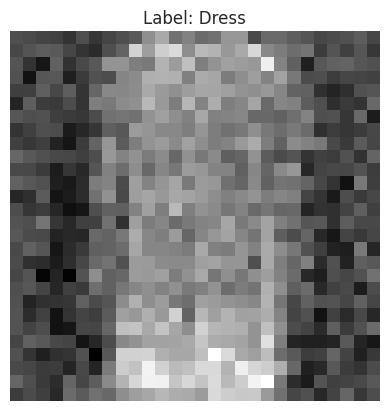

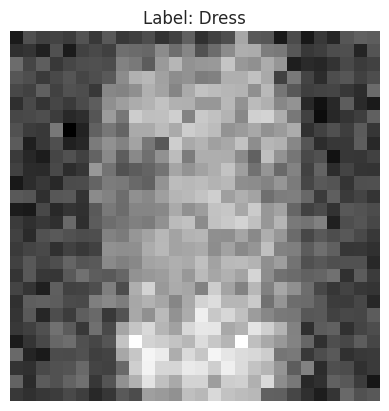

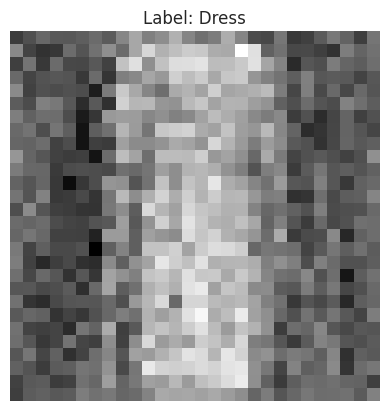

In [44]:
lda_model = lda["cls"]
top_X, top_y = generate_samples_from_lda(lda_model, 5, 0)
dress_X, dress_y = generate_samples_from_lda(lda_model, 5, 1)

for i in range(5):
    display_image(top_X, top_y, i)
for i in range(5):
    display_image(dress_X, dress_y, i)

## Redukce dimenzionality


V této sekci vyzkoušíme metody redukce dimenzionality (jmenovitě PCA a LLE).

SVM model je odolný vysokým dimenzím, nečekáme tedy zásadní zlepšení.

Pro model Naivního Bayese by mohla být redukce dimenzionality prospěšná.

Model LDA již používá vestavěnou redukci dimenzionality, neočekáváme tedy zlepšení.


In [29]:
from copy import deepcopy

reducer_names = ["no-reducing", "PCA", "LLE"]
reducers = ["passthrough", PCA(), LocallyLinearEmbedding()]
reducer_grids: list[dict] = [
    {},
    {
        "reducer__n_components": [None, 10, 15, 20, 100, 250, 500],
    },
    {
        "reducer__n_components": [20, 30, 40, 50, 64, 100, 250, 500],
        "reducer__n_neighbors": [20, 30],
    },
]

pipeline_names = ["SVM", "GNB", "LDA"]
pipelines = [
    Pipeline(
        [
            ("scaler", None),
            ("reducer", None),
            ("cls", SVC()),
        ]
    ),
    Pipeline(
        [
            ("scaler", None),
            ("reducer", None),
            ("cls", GaussianNB()),
        ]
    ),
    Pipeline(
        [
            ("scaler", None),
            ("reducer", None),
            ("cls", LinearDiscriminantAnalysis()),
        ]
    ),
]
pipeline_grids_backup = [{}, {}, {}]
pipeline_grids: list[dict] = [
    {
        "scaler": None,
        "cls__kernel": ["rbf", "poly"],
        "cls__C": [
            1,
            5,
        ],
    },
    {"cls__var_smoothing": [0.01, 1e-09, 1e-08, 1e-07]},
    [
        {
            "scaler": None,
            "cls__solver": ["svd"],
        },
        {
            "scaler": None,
            "cls__solver": ["lsqr"],
            "cls__shrinkage": [0.3, 0.4, 0.5],
        },
    ],
]

Redukce dimenzionality nebyla pro model SVM příliš prospěšná (rozdíly jsou zanedbatelné).

Nejprospěšnější byla redukce dimenzionality pro model GNB. Úspěšná byla metoda PCA (ta nejlépe fungovala se standardizací) i LLE (zde škálování nemělo větší efekt).

Na model LDA také neměla redukce dimenzionality zásadní pozitivní vliv.

Metoda PCA obvykle volila pro **n_components** hodnotu 100, metoda LDA většinou volila hodnotu 250.


In [30]:
def test_dimensionality_reduction(X, y):
    for pipeline, pipeline_name, pipeline_grid in zip(
        pipelines, pipeline_names, pipeline_grids
    ):
        for reducer, reducer_name, reducer_grid in zip(
            reducers, reducer_names, reducer_grids
        ):
            grid = deepcopy(pipeline_grid)

            if isinstance(grid, list):
                for dictionary in grid:
                    dictionary["reducer"] = [reducer]
                    dictionary.update(reducer_grid)
            else:
                grid["reducer"] = [reducer]
                grid.update(reducer_grid)

            print(f"\nTesting {reducer_name} with {pipeline_name}:\n")
            test_scalers(f"{reducer_name}-{pipeline_name}", grid, pipeline, X, y)


test_dimensionality_reduction(X_train, y_train)


Testing no-reducing with SVM:

Best score (no-reducing-SVM-no-scaling) = 0.95, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'reducer': 'passthrough', 'scaler': 'passthrough'}
Best score (no-reducing-SVM-standard-scaling) = 0.9511111111111111, with hyperparameters: {'cls__C': 5, 'cls__kernel': 'poly', 'reducer': 'passthrough', 'scaler': StandardScaler()}
Best score (no-reducing-SVM-min-max-scaling) = 0.9488888888888889, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'reducer': 'passthrough', 'scaler': MinMaxScaler()}
Best score (no-reducing-SVM-divide-scaling) = 0.95, with hyperparameters: {'cls__C': 1, 'cls__kernel': 'rbf', 'reducer': 'passthrough', 'scaler': DivideScaler()}

Testing PCA with SVM:

Best score (PCA-SVM-no-scaling) = 0.9533333333333334, with hyperparameters: {'cls__C': 5, 'cls__kernel': 'rbf', 'reducer': PCA(), 'reducer__n_components': 100, 'scaler': 'passthrough'}
Best score (PCA-SVM-standard-scaling) = 0.9555555555555555, with hyperparameters: 

## Nejlepší model

Na základě poznatků z předešlých sekcí sestrojíme nejlepší model. Kandidáti jsou SVM (potenciálně se standardizací a PCA) a LDA (pravděpodobně bez redukce škálování a redukce dimenzionality).


In [31]:
best_scalers = ["passthrough", StandardScaler()]
best_reducers = ["passthrough", PCA()]
best_reducer_grids = [
    {},
    {"reducer__n_components": [75, 100, 125]},
]

cls_grid_svm = [
    {
        "cls__kernel": ["rbf"],
        "cls__C": [0.1, 1, 10],
        "cls__gamma": ["scale", 0.001, 0.01, 0.1, 1, 10],
    },
    {
        "cls__kernel": ["poly"],
        "cls__C": [0.1, 1, 10],
        "cls__gamma": ["scale", 0.01, 0.1, 1],
    },
    {
        "cls__kernel": ["sigmoid"],
        "cls__C": [0.1, 1, 10],
        "cls__gamma": ["scale", 0.001, 0.01, 0.1],
    },
]

best_grid_pca_svm = []
best_grid_svm = []

output_grids = [best_grid_svm, best_grid_pca_svm]

for scaler in best_scalers:
    for option in cls_grid_svm:
        for reducer, reducer_grid, output_grid in zip(
            best_reducers, best_reducer_grids, output_grids
        ):
            option_copy = deepcopy(option)
            option_copy["scaler"] = [scaler]
            option_copy["reducer"] = [reducer]
            option_copy.update(reducer_grid)
            output_grid.append(option_copy)

best_pipeline_svm = Pipeline([("scaler", None), ("reducer", None), ("cls", SVC())])

best_svm = tune_hyperparameters(
    "Best no-reduction SVM",
    best_grid_svm,
    best_pipeline_svm,
    X_train,
    y_train,
    verbose=1,
    random=False,
)

best_pca_svm = tune_hyperparameters(
    "Best PCA SVM",
    best_grid_pca_svm,
    best_pipeline_svm,
    X_train,
    y_train,
    verbose=1,
    random=False,
)

Fitting 5 folds for each of 84 candidates, totalling 420 fits
Best score (Best no-reduction SVM) = 0.9522222222222222, with hyperparameters: {'cls__C': 10, 'cls__gamma': 'scale', 'cls__kernel': 'poly', 'reducer': 'passthrough', 'scaler': StandardScaler()}
Fitting 5 folds for each of 252 candidates, totalling 1260 fits
Best score (Best PCA SVM) = 0.9566666666666667, with hyperparameters: {'cls__C': 10, 'cls__gamma': 'scale', 'cls__kernel': 'poly', 'reducer': PCA(), 'reducer__n_components': 75, 'scaler': StandardScaler()}


In [32]:
best_grid_lda = [
    {"cls__solver": ["svd"]},
    {
        "cls__solver": ["lsqr"],
        "cls__shrinkage": [None, "auto", 0.1, 0.3, 0.5, 0.7, 0.9],
    },
]

best_pipeline_lda = Pipeline([("cls", LinearDiscriminantAnalysis())])

best_lda = tune_hyperparameters(
    "Best LDA", best_grid_lda, best_pipeline_lda, X_train, y_train, verbose=1
)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best score (Best LDA) = 0.9444444444444444, with hyperparameters: {'cls__shrinkage': 0.5, 'cls__solver': 'lsqr'}


### Evaluace

Získali jsme 3 nejlepší modely. Nejlepší přesnosti dosáhla varianta SVM s PCA (rozdíl je 0.5%). K další evaluaci použijeme dříve zavedenou funkci.


Evaluating Best no-reduction SVM model
 - Prediction time = 0.02 seconds
 - Accuracy = 93.00%
 - F1 score = 92.31%

Classification report
              precision    recall  f1-score   support

         Top       0.93      0.94      0.94       163
       Dress       0.93      0.92      0.92       137

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


Missclassified images


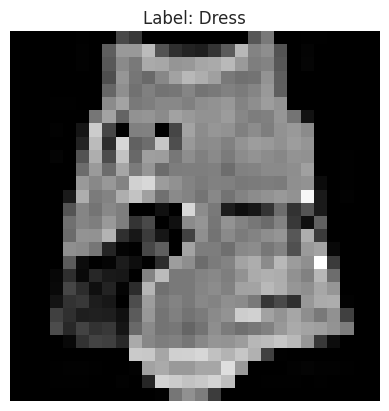

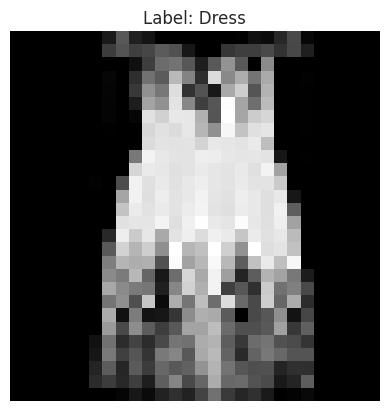

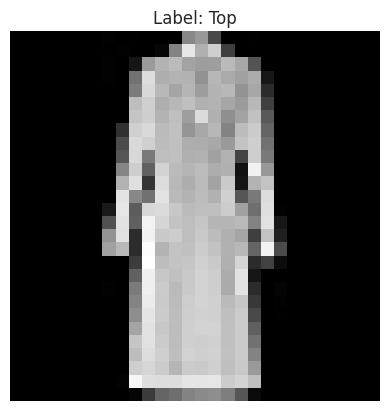

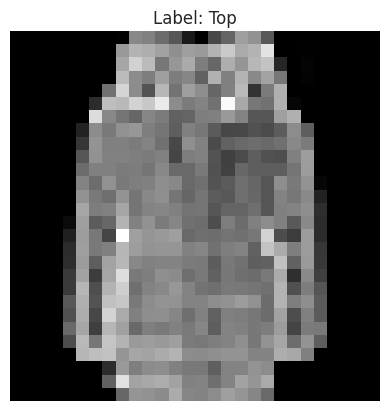

0.93

In [33]:
evaluate_model("Best no-reduction SVM", best_svm, X_val, y_val)

Evaluating Best PCA SVM model
 - Prediction time = 0.01 seconds
 - Accuracy = 92.33%
 - F1 score = 91.70%

Classification report
              precision    recall  f1-score   support

         Top       0.94      0.92      0.93       163
       Dress       0.91      0.93      0.92       137

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300


Missclassified images


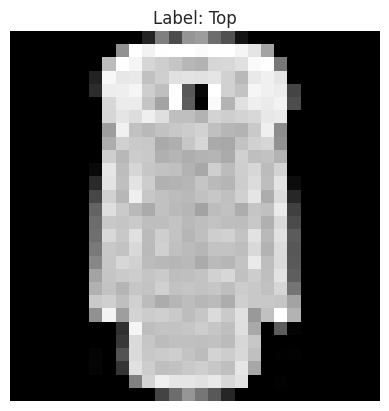

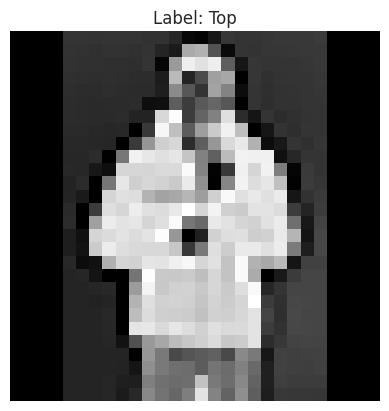

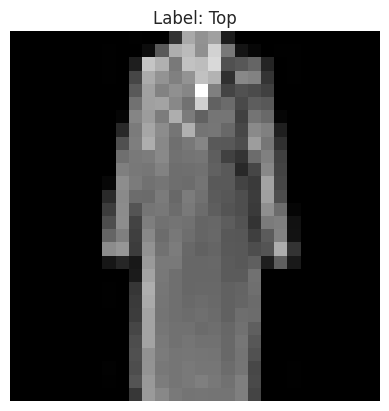

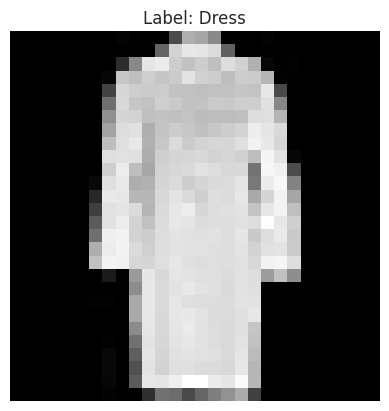

0.9233333333333333

In [34]:
evaluate_model("Best PCA SVM", best_pca_svm, X_val, y_val)

Evaluating Best LDA model
 - Prediction time = 0.00 seconds
 - Accuracy = 91.67%
 - F1 score = 90.97%

Classification report
              precision    recall  f1-score   support

         Top       0.93      0.91      0.92       163
       Dress       0.90      0.92      0.91       137

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300


Missclassified images


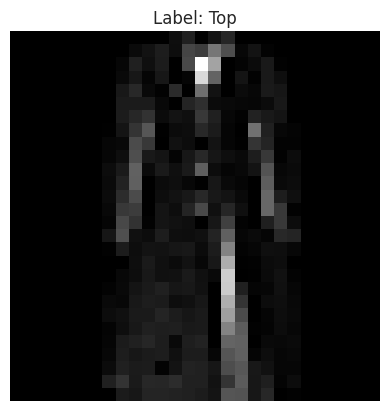

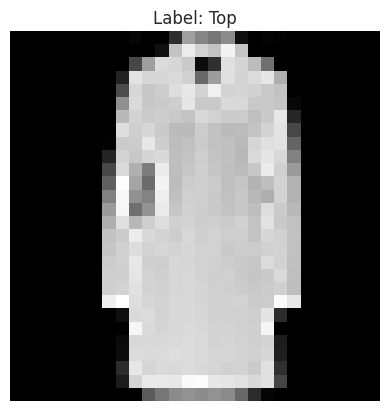

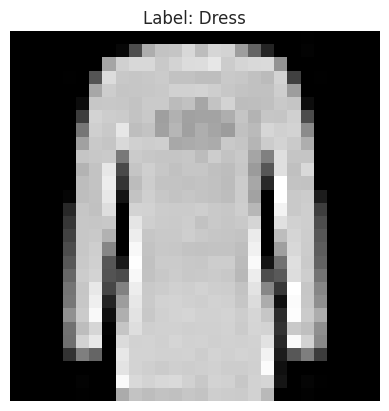

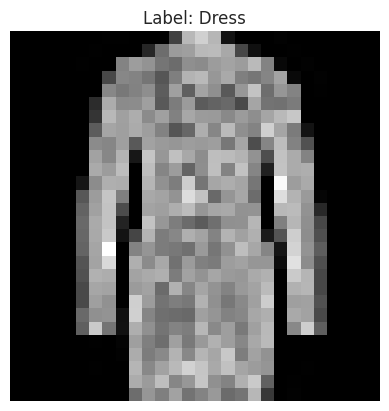

0.9166666666666666

In [35]:
evaluate_model("Best LDA", best_lda, X_val, y_val)

Na validační datech si nejlépe vedl model SVM bez redukce dimenzionality. Především i kvůli jednoduchosti a lepší interpretovatelnosti zvolíme právě tento model.

Je nutno podotknout, že si velmi dobře vedli všechny 3 získané modely. Ze špatně klasifikovaných příkladů je zřejmé, že rozeznat jednotlivé třídy v některých případech není jednoduché ani pro člověka.


## Finální predikce

Následně použijeme nejlepší model k predikci tříd na neznámých datech. Nejdříve ale odhadneme přesnost predikce na neznámych datech pomocí testovací množiny.

Na testovacích datech dosahuje model přesnosti 95%. Vzhledem k tomu, že se jedná o vyšší odhad než u validační množiny a u trénovací množiny s použitím křížové validace, budeme výsledek považovat jako horní hranici odhadované přesnosti. Očekával bych tedy přesnost spíše okolo 93%.


Evaluating Best SVM model
 - Prediction time = 0.01 seconds
 - Accuracy = 95.00%
 - F1 score = 94.62%

Classification report
              precision    recall  f1-score   support

         Top       0.94      0.97      0.95       158
       Dress       0.96      0.93      0.95       142

    accuracy                           0.95       300
   macro avg       0.95      0.95      0.95       300
weighted avg       0.95      0.95      0.95       300


Missclassified images


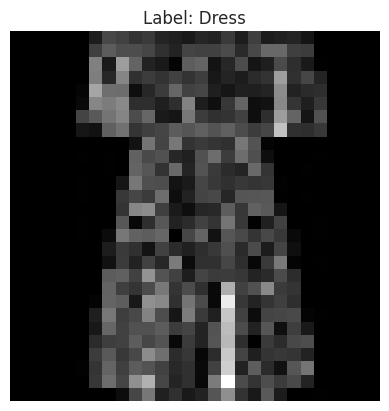

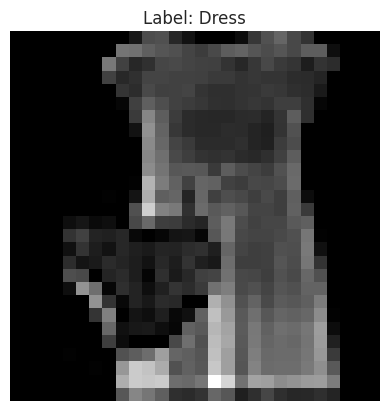

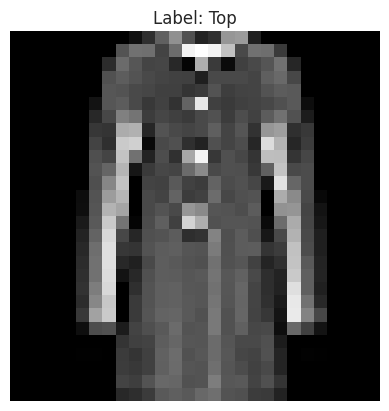

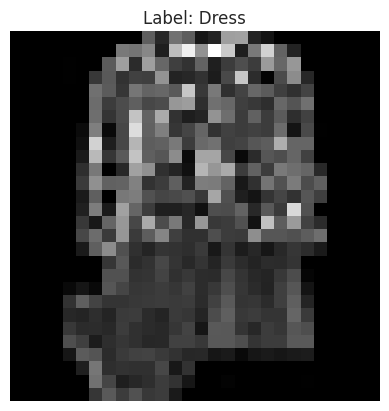

0.95

In [36]:
evaluate_model("Best SVM", best_svm, X_test, y_test)

Pokračujeme načtením datasetu k predikci.


In [37]:
evaluate_df = pd.read_csv("evaluate.csv")
evaluate_df.head()

,ID,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,0,0,0,0,0,0,0,1,0,...,87,5,0,0,1,0,0,0,0,0
3,3,0,0,0,0,0,0,0,0,0,...,2,0,15,144,139,0,0,0,0,0
4,4,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Vytvoříme nový soubor results.csv, do kterého nahrajeme predikované hodnoty.


In [55]:
ids_evaluate = evaluate_df["ID"]
X_evaluate = evaluate_df.drop(columns=["ID"])
y_evaluate = best_svm.predict(X_evaluate)

result_columns = ["ID", "label"]
results_df = pd.DataFrame({"ID": ids_evaluate, "label": y_evaluate})
results_df = results_df[result_columns]
results_df.to_csv("results.csv", index=False)
results_df.head()

,ID,label
0,0,1
1,1,0
2,2,0
3,3,0
4,4,0


Zda predikce proběhla správně zkontrolujeme okometricky na pár vybraných příkladech.


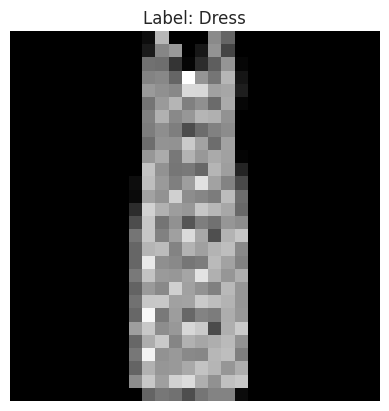

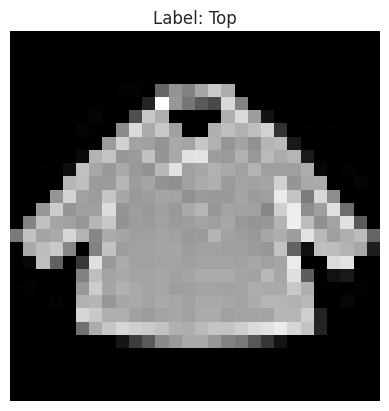

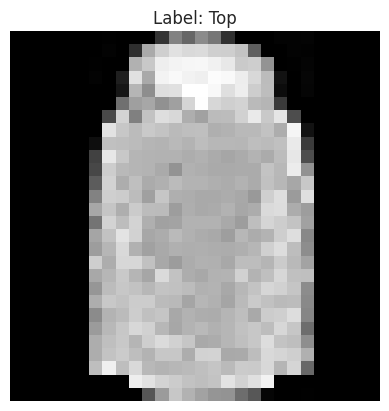

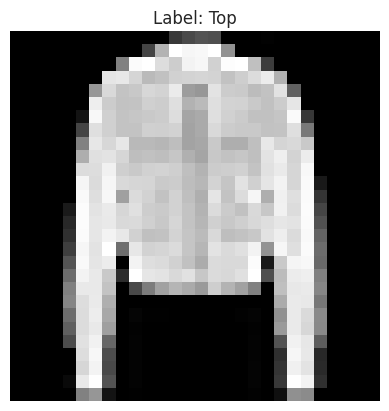

In [56]:
display_image(X_evaluate, y_evaluate, 0)
display_image(X_evaluate, y_evaluate, 1)
display_image(X_evaluate, y_evaluate, 2)
display_image(X_evaluate, y_evaluate, 3)